参考链接
https://nbviewer.jupyter.org/github/poppinkingone/jupyter_test/blob/master/Option.ipynb

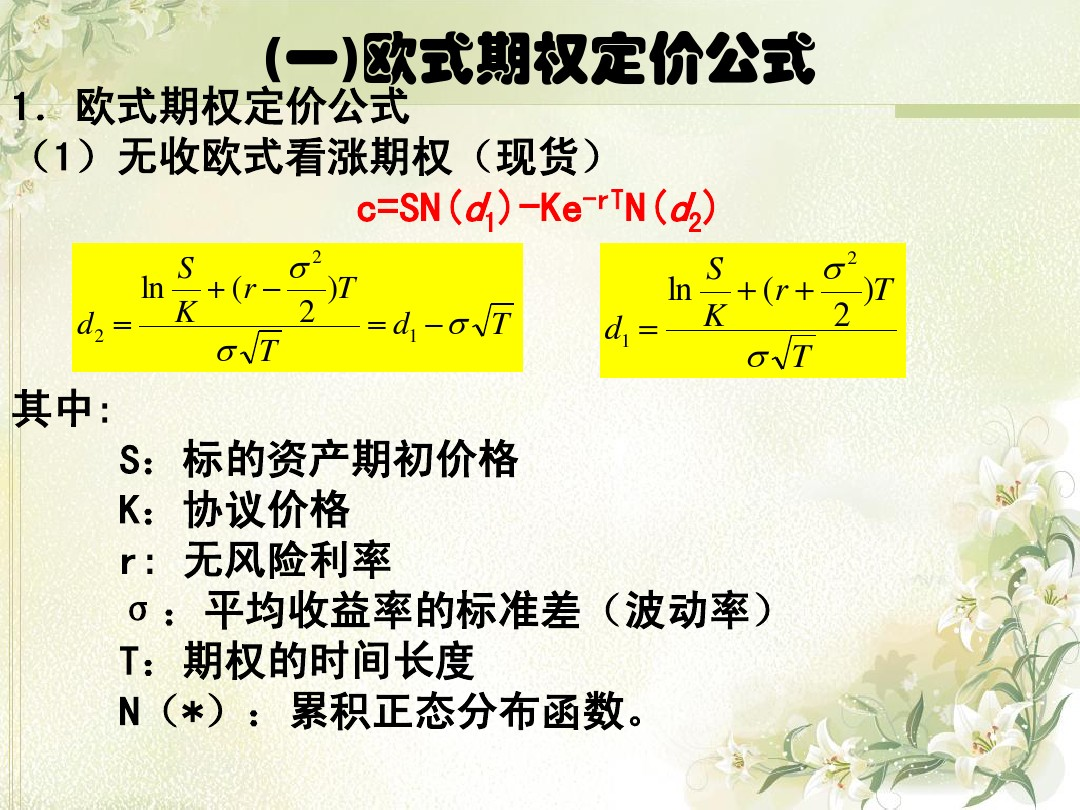

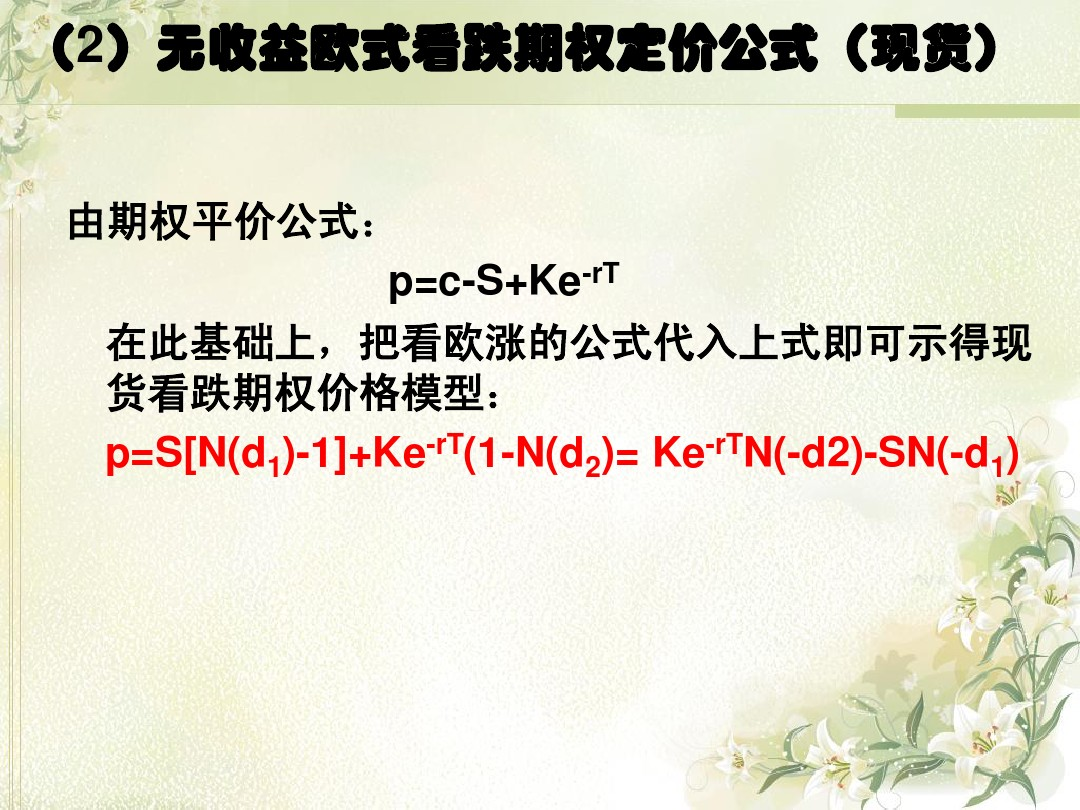

In [146]:
from math import log,sqrt,exp
from scipy import stats

In [147]:
#定义参数，其中利率和波动率是百分位计数
parameter = {'标的价格':2.724,'行权价':2.7,'无风险利率':0.044,'到期天数':218/365,'历史波动率':0.2668}
call_price,put_price = 0.2236,0.1365
get_parm = parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],parameter['到期天数'],parameter['历史波动率']
get_parm

(2.724, 2.7, 0.044, 0.5972602739726027, 0.2668)

# 期权BS定价模型
## d1 = (ln(st/k)+(r+1/2\*sigma\***2)\*T)/(sigma\*sqrt(T))
## d2 = d1 - sigma\*sqrt(T)
## call = st \*N(d1)-k \*exp(-r \*T) \*N(d2)
## put = k\*exp(-r\*T)\*N(-d2)-st\*N(-d1)


In [148]:
def call(st,k,r,T,sigma):
    '''
    st,k,r,T,sigma(T以年为单位，天数应该除以365)
    '''
    d1 = (log(st/k)+(r+1/2*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    call = st*stats.norm.cdf(d1,0.0,1.0)-k*exp(-r*T)*stats.norm.cdf(d2,0.0,1.0)
    return call
def put(st,k,r,T,sigma):
    '''
    st,k,r,T,sigma(T以年为单位，天数应该除以365)
    '''
    d1 = (log(st/k)+(r+1/2*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    put = k*exp(-r*T)*stats.norm.cdf(-1*d2)-1*st*stats.norm.cdf(-1*d1)
    return put

In [149]:
a = call(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],parameter['到期天数'],parameter['历史波动率'])
b = put(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],parameter['到期天数'],parameter['历史波动率'])
a,b

(0.26999977280918164, 0.1759694616179488)

# Delta
## call :delta = N(d1)
## put :delta = N(-d1)

In [150]:
def delta(st,k,r,T,sigma,n=1):
    '''
    n默认为1看涨期权的delta
    n为-1为看跌期权的delta
    '''
    d1 = (log(st/k)+(r+1/2*sigma**2)*T)/(sigma*sqrt(T))
    delta = n*stats.norm.cdf(n*d1)
    return delta


In [151]:
d = delta(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],
          parameter['到期天数'],parameter['历史波动率'])
d

0.6077529900198664

# Gamma
##  gamma = N'(d1)/(st\*sigma\*sqrt(T))

In [152]:
def gamma(st,k,r,T,sigma):
    d1 = (log(st/k)+(r+1/2*sigma**2)*T)/(sigma*sqrt(T))
    gamma = stats.norm.pdf(d1)/(st*sigma*sqrt(T))
    return gamma

In [153]:
g = gamma(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],
          parameter['到期天数'],parameter['历史波动率'])
g

0.6842205339969426

# Theta
## call: theta = -1\*(st\*N'(d1)\*sigma)/(2\*sqrt(T))-r×k\*exp(-r \*T)\*N(d2)
## put:theta = -1\*(st\*N'(d1)\*sigma)/(2\*sqrt(T))+r×k\*exp(-r \*T)\*N(-1\*d2)

In [154]:
def theta(st,k,r,T,sigma,n=1):
    '''
    n默认为1看涨期权的delta
    n为-1为看跌期权的delta
    '''
    d1 = (log(st/k)+(r+1/2*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1-sigma*sqrt(T)
    theta = -1*(st*stats.norm.pdf(d1)*sigma)/(2*sqrt(T))-n*r*k*exp(-r*T)*stats.norm.cdf(n*d2)
    return theta

In [155]:
t = theta(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],
          parameter['到期天数'],parameter['历史波动率'])
t

-0.2416602778301039

# Vega
## vega = st\*sqrt(T)*N'(d1)

In [156]:
def vega(st,k,r,T,sigma):
    d1 = (log(st/k)+(r+1/2*sigma**2)*T)/(sigma*sqrt(T))
    vega = st*sqrt(T)*stats.norm.pdf(d1)
    return vega

In [157]:
v = vega(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],
                     parameter['到期天数'],parameter['历史波动率'])
v

0.8090209433096737

# 隐含波动率

In [158]:
#牛顿迭代法求隐含波动率，迭代次数设为100
def call_imp_vol_newton(s0, k, r,t,c0, sigma_est, it = 100):    
    for i in range(it):
        sigma_est -= ((call(s0, k, r,t, sigma_est) - c0)/ 
                      vega(s0, k, r,t, sigma_est))
    return sigma_est
def put_imp_vol_newton(s0, k, r,t,c0, sigma_est, it = 100):    
    for i in range(it):
        sigma_est -= ((put(s0, k, r,t, sigma_est) - c0)/ 
                      vega(s0, k, r,t, sigma_est))
    return sigma_est

In [159]:
sigma_init_call=1
sigma_init_put=1

In [160]:
call_imp = call_imp_vol_newton(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],
                     parameter['到期天数'],call_price,sigma_init_call)
call_imp

0.20927908375262202

In [161]:
put_imp = put_imp_vol_newton(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],
                     parameter['到期天数'],put_price,sigma_init_put)
put_imp

0.21789894094734524

In [166]:
#二分法求隐含波动率
def call_imp_vol_dichotomy(s0,k,r,t,c):
    c_est = 0
    top = 3  #波动率上限
    floor = 0  #波动率下限
    sigma = ( floor + top )/2 #波动率初始值
    
    while abs( c - c_est ) > 1e-8:
        c_est = call(s0,k,r,t,sigma) 
        #根据价格判断波动率是被低估还是高估，并对波动率做修正
        if c - c_est > 0: #f(x)>0
            floor = sigma
            sigma = ( sigma + top )/2
        else:
            top = sigma
            sigma = ( sigma + floor )/2
    return sigma

def put_imp_vol_dichotomy(s0,k,r,t,c):
    c_est = 0
    top = 3  #波动率上限
    floor = 0  #波动率下限
    sigma = ( floor + top )/2 #波动率初始值
    
    while abs( c - c_est ) > 1e-8:
        c_est = put(s0,k,r,t,sigma) 
        #根据价格判断波动率是被低估还是高估，并对波动率做修正
        if c - c_est > 0: #f(x)>0
            floor = sigma
            sigma = ( sigma + top )/2
        else:
            top = sigma
            sigma = ( sigma + floor )/2
    return sigma

In [168]:
call_imp2 = call_imp_vol_dichotomy(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],
                     parameter['到期天数'],call_price)
call_imp2

0.20927904546260834

In [169]:
put_imp2 = put_imp_vol_dichotomy(parameter['标的价格'],parameter['行权价'],parameter['无风险利率'],
                     parameter['到期天数'],put_price)
put_imp2

0.217898927628994